In [307]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
import gseapy as gp
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import warnings

In [308]:
# ignore pd warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)

# load csv
model = '/Users/connormullins/Excel sheets/Model.csv'
osm = '/Users/connormullins/Excel sheets/OmicsSomaticMutations.csv'
effect = '/Users/connormullins/Excel sheets/CRISPRGeneEffect.csv'

# file path of gene set in gmt format
kegg = gp.read_gmt(path = '/Users/connormullins/Downloads/c2.cp.kegg_medicus.v2024.1.Hs.symbols.gmt')
pid = gp.read_gmt(path = '/Users/connormullins/Downloads/c2.cp.pid.v2024.1.Hs.symbols.gmt')
biocarta = gp.read_gmt(path = '/Users/connormullins/Downloads/c2.cp.biocarta.v2024.1.Hs.symbols (1).gmt')

In [226]:
# use this later
def extract_middle(label):
    parts = label.split('_')
    if len(parts) == 4:
        return f"{parts[1]}_{parts[2]}"
    else:
        return parts[1]

In [3]:
model_df = pd.read_csv(model, header=0, index_col=0)
osm_df = pd.read_csv(osm, header=0, low_memory=False)
effect_df = pd.read_csv(effect, header=0, index_col=0)

In [309]:
cancer_type = "COAD"
protein = "KRAS"
gene_change = ['p.G13D', 'p.G12V', 'p.G12D', 'p.A146T']

In [310]:
def rungsea(cancer, protein, mutation):

    appended_results = []
    
    for mut in gene_change:
        cancer_filter = model_df[model_df['OncotreeCode'] == cancer]
        osm_filter_pie = cancer_filter.merge(osm_df, on=['ModelID'], how='inner')
        protein_filter = osm_filter_pie[(osm_filter_pie['HugoSymbol'] == protein)]
        protein_change_filter = protein_filter[(protein_filter['ProteinChange']== mut)]
        protein_change_filter = protein_change_filter.filter(['ModelID'])

        #retrieve wt cell lines-- models have same oncotree code but not gene mutation specified
        cancer_filter = cancer_filter.reset_index()
        cancer_filter = cancer_filter.filter(['ModelID'])
        protein_filter = protein_filter.filter(['ModelID'])
        wt_and_mutant = pd.concat([cancer_filter, protein_filter])
        wt_gene = wt_and_mutant.drop_duplicates(keep = False)


        # merging gene effect with WT and MUT groups
        effect_mutant = protein_change_filter.merge(effect_df, on = ['ModelID'], how = 'inner')
        effect_mutant = effect_mutant.set_index('ModelID')
        effect_wt = wt_gene.merge(effect_df, on = ['ModelID'], how = 'inner')
        effect_wt = effect_wt.set_index('ModelID')


        # t test
        _, p_value = scipy.stats.ttest_ind(effect_wt, effect_mutant)
        pvalue_df = pd.DataFrame(p_value)
        pvalue_df = pvalue_df.set_index(effect_df.columns)
        pvalue_df = pvalue_df.rename(columns = {0 : 'p-value'})

        # use only significant differentially expressed genes
        sig_pv = pvalue_df[pvalue_df['p-value'] < 0.05]
        sig_pv = sig_pv.reset_index()
        sig_pv['gene name'] = sig_pv['index'].apply(lambda x: x.split(' ')[0])

        rnk = pd.DataFrame()
        rnk['scores'] = abs(effect_mutant.mean(axis = 0, skipna=True, numeric_only=True))
        rnk = rnk.reset_index()
        rnk = rnk.rename(columns = {'index' : 'gene'})
        rnk = rnk.sort_values('scores', ascending = False)
        rnk['gene'] = rnk['gene'].apply(lambda x: x.split(' ')[0])
        rnk = rnk.dropna()

        enr = gp.prerank(rnk = rnk,
                         gene_sets = pid,
                         max_size = 10000,
                         seed = 6, permutation_num = 1000)
        res = enr.res2d.sort_values('NES', ascending = False)

        filtered_res = res[res['FDR q-val'] < 0.25]
        filtered_res['shortened'] = filtered_res['Term'].apply(extract_middle)

        filtered_res['mutation'] = mut
        appended_results.append(filtered_res)

    final_results = pd.concat(appended_results, ignore_index=True)
    pd.DataFrame(final_results)

    return final_results


In [311]:
df = rungsea(cancer_type, protein, gene_change)

/var/folders/k9/bz30f50d0bv1pzq8kv4wkg4h0000gn/T/ipykernel_30921/2697024392.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_res['shortened'] = filtered_res['Term'].apply(extract_middle)
/var/folders/k9/bz30f50d0bv1pzq8kv4wkg4h0000gn/T/ipykernel_30921/2697024392.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_res['mutation'] = mut
/var/folders/k9/bz30f50d0bv1pzq8kv4wkg4h0000gn/T/ipykernel_30921/2697024392.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

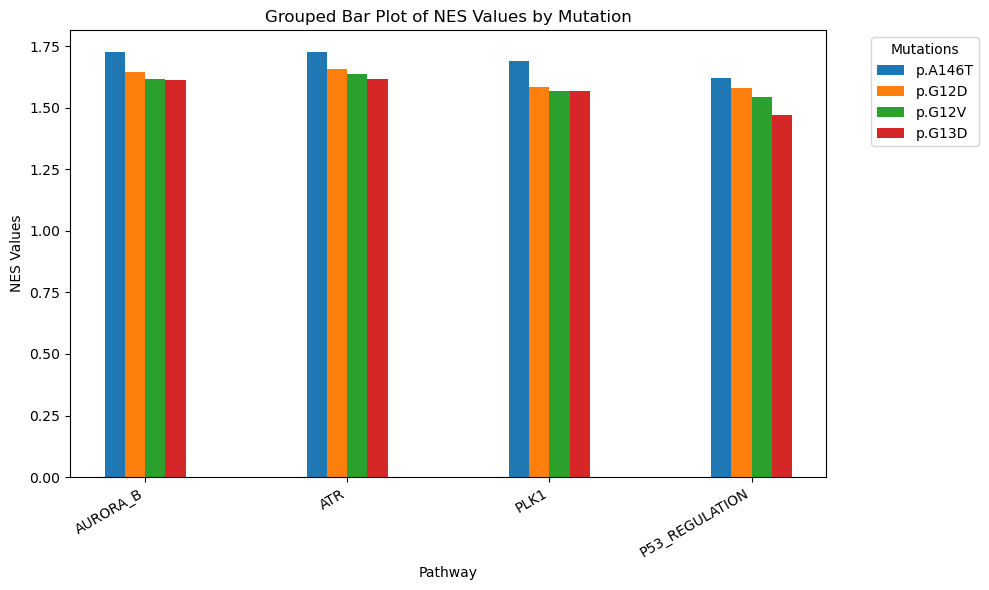

In [319]:
merged_df = None

dfs = {mutation: group for mutation, group in df.groupby('mutation')}
for mutant, mutant_df in dfs.items():

    mutant_df = mutant_df[['shortened', 'NES']].head(7)
    mutant_df.columns = ['pathway', mutant]
    
    if merged_df is None:
        merged_df = mutant_df
    else:
        merged_df = merged_df.merge(mutant_df, on='pathway', how='inner')  # Inner merge to keep shared values only

if merged_df is not None:
    merged_df.set_index('pathway', inplace=True)

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(merged_df.index))  # Positions for the pathways
width = 0.1  # Width of each bar

# Create a bar for each mutation
for i, mutation in enumerate(merged_df.columns):
    ax.bar(x + i * width, merged_df[mutation], width, label=mutation)

# Customizing the plot
ax.set_xlabel('Pathway')
ax.set_ylabel('NES Values')
ax.set_title('Grouped Bar Plot of NES Values by Mutation')
ax.set_xticks(x + width * (len(merged_df.columns) - 1) / 2)  # Center ticks under groups
ax.set_xticklabels(merged_df.index, rotation=30, ha='right')
ax.legend(title='Mutations', bbox_to_anchor=(1.05, 1), loc='upper left')

# Optimize layout and show the plot
plt.tight_layout()
plt.show()